# WRF cold bias comparison

This notebook is for investigating cold bias in the WRF ERA-Interim data. It was created in preparation for a meeting with the dataset originators (i.e. dyndown group) to discuss this bias and related datasets. 

We will be using the "NCAR" dataset to compare against, because it was generated with a different downscaling method (statistical) and also has a historical "baseline" product (Daymet) for comparing with ERA-Interim. This may be confusing, but the "NCAR" dataset includes NCAR CCSM4 as a model, as does the 20km WRF dataset. 

In [1]:
# for pandas /xarray futurewarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xarray as xr
from pyproj import Transformer
from pyproj.crs import CRS
import pandas as pd
import numpy as np

Set the coordinates we will do point extractions for:

In [10]:
wgs84_coords = {
    "Palmer": (61.6, -149.113),
    "Valdez": (61.131, -146.348),
    "Talkeetna": (62.321, -150.107),
    "Nome": (64.5, -165.409),
    "Fort Yukon": (66.564, -145.249),
    "Skagway": (59.457, -135.315),
}

Get projection info from single file:

In [11]:
with xr.open_dataset("/rcs/project_data/wrf_data/daily/t2max/t2max_daily_wrf_ERA-Interim_historical_1980.nc") as ds:
    # project WGS84 coordinates using proj string from WRF file
    wrf_proj_str = ds.attrs["proj_parameters"]
    wrf_crs = CRS.from_proj4(wrf_proj_str)
    
transformer = Transformer.from_crs("epsg:4326", wrf_crs)

Function to extract from ERA-Interim (WRF):

In [12]:
def extract_wrf(coords_di, varname):
    """Supply a dict of locations and return a dataframe of extractions for those points"""
    fn_str = f"/rcs/project_data/wrf_data/daily/{varname}/{varname}_daily_wrf_ERA-Interim_historical_*.nc"
    with xr.open_mfdataset(fn_str) as ds:
        wrf_coords = {
            p_name: transformer.transform(*coords)
            for p_name, coords in coords_di.items()
        }

        # query xarray dataset using "method" parameter to
        #   choose nearest cell to each coordinate
        data = {
            p_name: ds[varname].sel(xc=coords[0], yc=coords[1], method="nearest").values - 273.15
            for p_name, coords in wrf_coords.items()
        }

    # make a pandas dataframe with time series from points as columns
    df = pd.DataFrame(data, index=ds.time.values)
    
    return df

Run the extractions:

In [13]:
%%time
tmax_era_df = extract_wrf(wgs84_coords, "t2max")

CPU times: user 2min 11s, sys: 11.8 s, total: 2min 23s
Wall time: 4min 7s


In [14]:
%%time
tmin_era_df = extract_wrf(wgs84_coords, "t2min")

CPU times: user 2min 10s, sys: 11.5 s, total: 2min 22s
Wall time: 4min 6s


Do the same for NCAR Daymet data:

In [15]:
def extract_ncar(coords_di, varname):
    """Supply a dict of locations and return a dataframe of extractions for those points"""
    fn_str = "/Data/Base_Data/Climate/AK_NCAR_12km/met/daymet/daymet_met_*.nc"
    with xr.open_mfdataset(fn_str) as ds:
        data = {}
        for p_name, coords in coords_di.items():
            # find extraction pixel via euclidena distance
            lat, lon = coords
            lat_grid = ds["latitude"].isel(time=0)
            lon_grid = ds["longitude"].isel(time=0)
            rmse = np.sqrt((lat_grid - lat) ** 2 + (lon_grid - lon) ** 2)
            y, x = np.where(rmse == rmse.min())
            
            data[p_name] = ds[varname].sel(y=y, x=x).squeeze().values
        
    # make a pandas dataframe with time series from points as columns
    df = pd.DataFrame(data, index=ds.time.values)
    df.index = pd.to_datetime(df.index.date)
    
    return df

In [16]:
%%time
tmax_daymet_df = extract_ncar(wgs84_coords, "tmax")

CPU times: user 1min 34s, sys: 13.5 s, total: 1min 48s
Wall time: 2min 38s


In [17]:
%%time
tmin_daymet_df = extract_ncar(wgs84_coords, "tmin")

CPU times: user 1min 29s, sys: 13 s, total: 1min 42s
Wall time: 1min 35s


## Comparison

Compare the ERA-Interim with the Daymet.

In [18]:
# join dataframes for plotting
start_date = "1980-01-01"
end_date = "2014-12-31"
tmin_df = tmin_daymet_df[start_date: end_date].join(tmin_era_df[start_date: end_date], lsuffix="_daymet", rsuffix="_era")
tmax_df = tmax_daymet_df[start_date: end_date].join(tmax_era_df[start_date: end_date], lsuffix="_daymet", rsuffix="_era")

### Daily timeseries plots

Plot the extracted daily time series data as line charts. Valdez and Palmer are locations where we know we have had user concerns about data validity.

#### Tmin

<AxesSubplot:title={'center':'Tmin, Palmer'}>

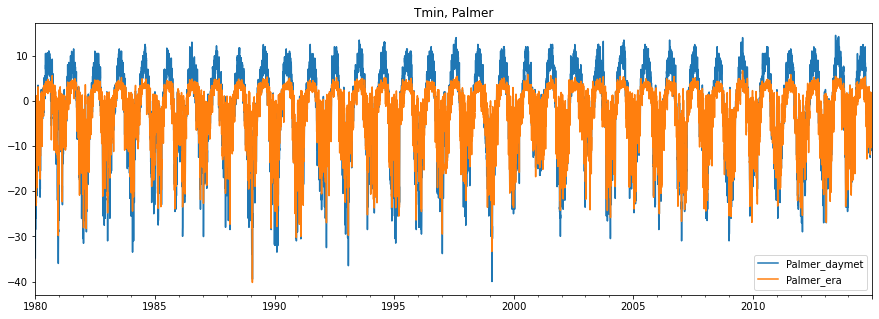

In [19]:
tmin_df[["Palmer_daymet", "Palmer_era"]].plot(figsize=(15,5), title="Tmin, Palmer")

<AxesSubplot:title={'center':'Tmin, Valdez'}>

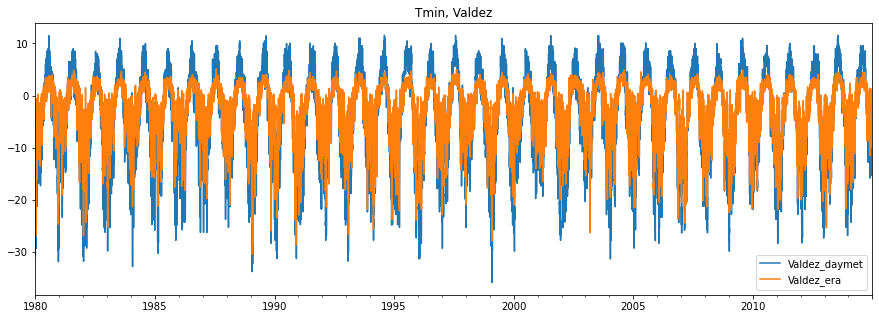

In [20]:
tmin_df[["Valdez_daymet", "Valdez_era"]].plot(figsize=(15,5), title="Tmin, Valdez")

#### Tmax

<AxesSubplot:title={'center':'Tmax, Palmer'}>

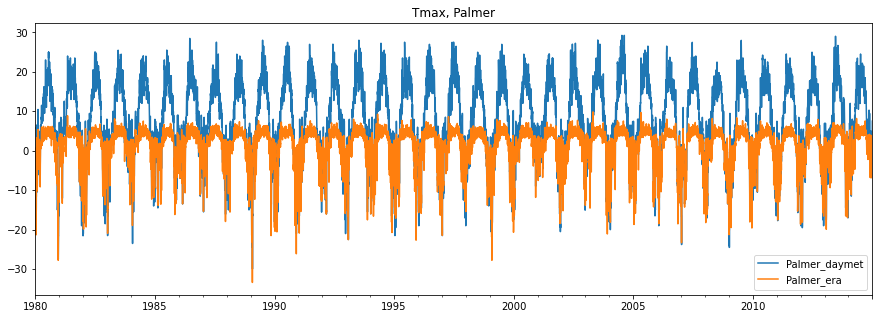

In [21]:
tmax_df[["Palmer_daymet", "Palmer_era"]].plot(figsize=(15,5), title="Tmax, Palmer")

<AxesSubplot:title={'center':'Tmax, Valdez'}>

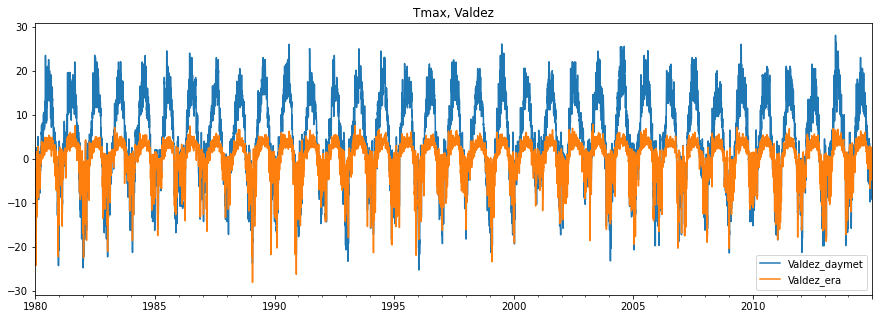

In [22]:
tmax_df[["Valdez_daymet", "Valdez_era"]].plot(figsize=(15,5), title="Tmax, Valdez")

### Tmax, other locations

Some other locations throughout AK.

<AxesSubplot:title={'center':'Tmax, Talkeetna'}>

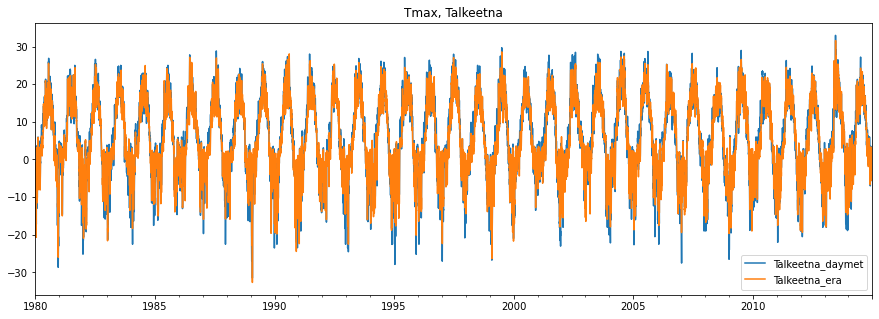

In [26]:
tmax_df[["Talkeetna_daymet", "Talkeetna_era"]].plot(figsize=(15,5), title="Tmax, Talkeetna")

<AxesSubplot:title={'center':'Tmax, Fort Yukon'}>

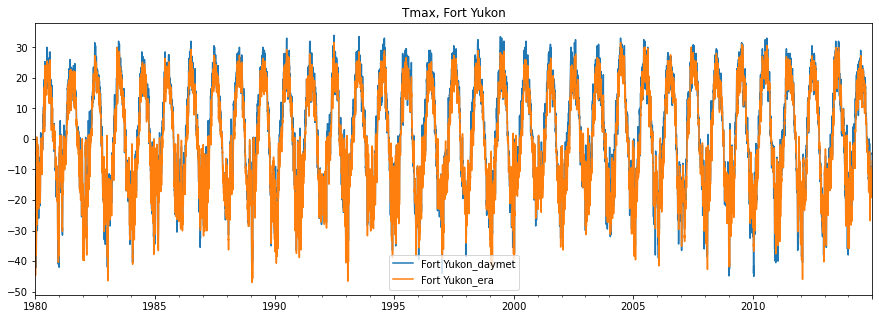

In [24]:
tmax_df[["Fort Yukon_daymet", "Fort Yukon_era"]].plot(figsize=(15,5), title="Tmax, Fort Yukon")

<AxesSubplot:title={'center':'Tmax, Skagway'}>

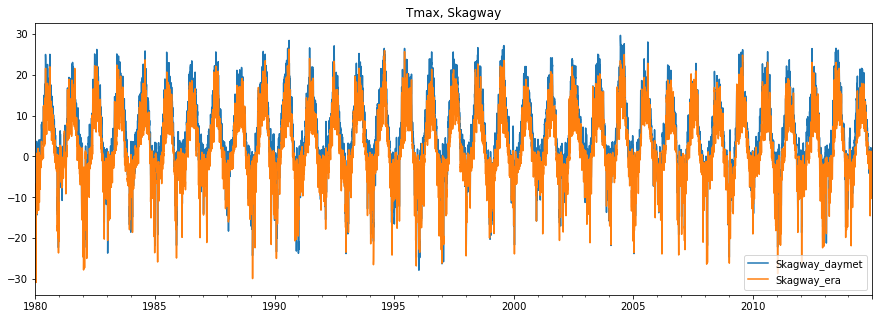

In [32]:
tmax_df[["Skagway_daymet", "Skagway_era"]].plot(figsize=(15,5), title="Tmax, Skagway")

#### Tmax deltas

Plot daily timeseries, like above, but using Tmax in ERA minus Tmax in Daymet.

In [1]:
def plot_deltas_ts(location):
    plot = (tmax_df[f"{location}_daymet"] - tmax_df[f"{location}_era"]).plot(figsize=(15,5), title=f"Tmax deltas, {location}")
    plot.axhline(y=0, color="red", linewidth=2, ls="--")

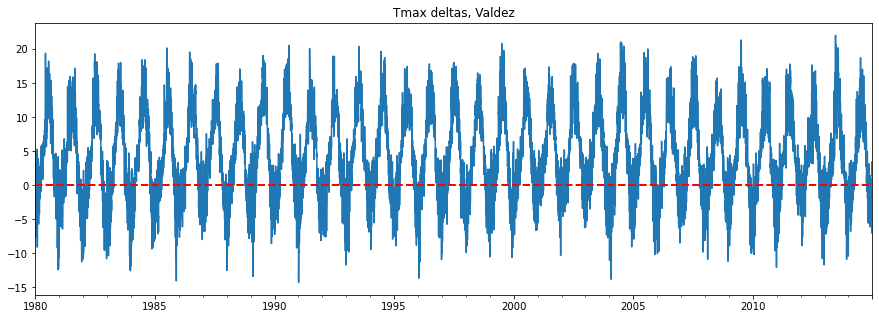

In [121]:
plot_deltas_ts("Valdez")

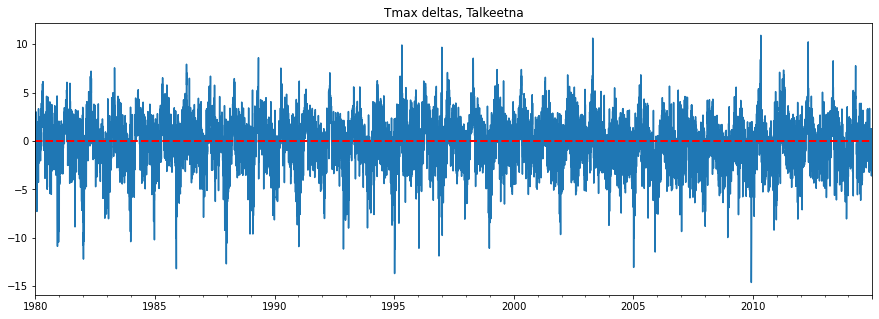

In [46]:
plot_deltas_ts("Talkeetna")

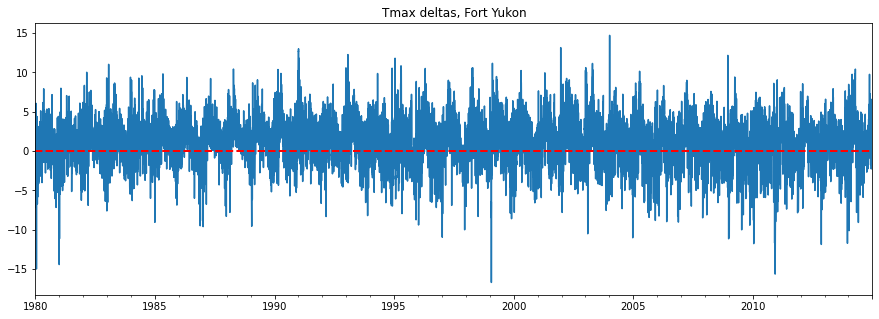

In [47]:
plot_deltas_ts("Fort Yukon")

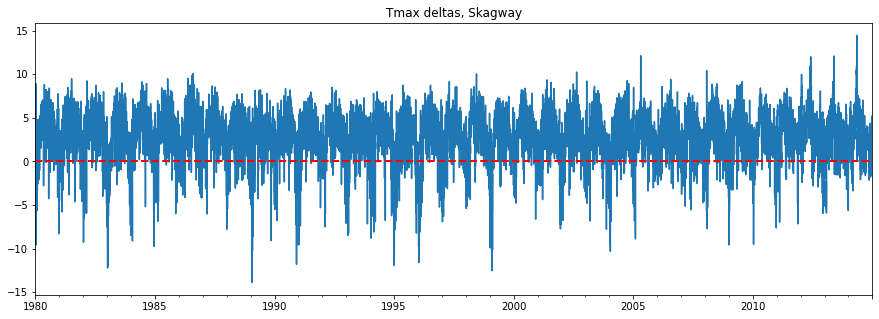

In [45]:
plot_deltas_ts("Skagway")

## Projected data

Here is a small comparison of projected tmax data, using NCAR CCSM4 from both the 20km WRF dataset and the NCAR dataset. This is only done for Valdez, for 2010-2030.

In [122]:
def extract_ncar_proj(coords_di, varname):
    """Supply a dict of locations and return a dataframe of extractions for those points"""
    fn_str = "/Data/Base_Data/Climate/AK_NCAR_12km/met/CCSM4/rcp85/CCSM4_rcp85_BCSD_met_{}.nc4"
    fps = [fn_str.format(year) for year in range(2010, 2029)]
    with xr.open_mfdataset(fps) as ds:
        data = {}
        for p_name, coords in coords_di.items():
            # find extraction pixel via euclidena distance
            lat, lon = coords
            lat_grid = ds["latitude"]
            lon_grid = ds["longitude"] - 360
            rmse = np.sqrt((lat_grid - lat) ** 2 + (lon_grid - lon) ** 2)
            y, x = np.where(rmse == rmse.min())
            print(x, y)
            data[p_name] = ds[varname].sel(y=y, x=x).squeeze().values
        
    # make a pandas dataframe with time series from points as columns
    df = pd.DataFrame(data, index=ds.time.values)
    df.index = pd.to_datetime(df.index.date)
    
    return df

In [123]:
def extract_wrf_proj(coords_di, varname):
    """Supply a dict of locations and return a dataframe of extractions for those points"""
    fn_str = f"/rcs/project_data/wrf_data/daily/{varname}/{varname}_daily_wrf_NCAR-CCSM4_rcp85_{{}}.nc"
    fps = [fn_str.format(year) for year in range(2010, 2029)]
    with xr.open_mfdataset(fps) as ds:
        wrf_coords = {
            p_name: transformer.transform(*coords)
            for p_name, coords in coords_di.items()
        }

        # query xarray dataset using "method" parameter to
        #   choose nearest cell to each coordinate
        data = {
            p_name: ds[varname].sel(xc=coords[0], yc=coords[1], method="nearest").values - 273.15
            for p_name, coords in wrf_coords.items()
        }

    # make a pandas dataframe with time series from points as columns
    df = pd.DataFrame(data, index=ds.time.values)
    
    return df

In [124]:
%%time
tmax_wrf_df_proj = extract_wrf_proj({"Valdez": (61.131, -146.348)}, "t2max")

CPU times: user 12.2 s, sys: 975 ms, total: 13.1 s
Wall time: 22.5 s


In [125]:
%%time
tmax_ncar_df_proj = extract_ncar_proj({"Valdez": (61.131, -146.348)}, "tmax")

[166] [78]
CPU times: user 9.82 s, sys: 1.05 s, total: 10.9 s
Wall time: 11.7 s


In [126]:
# join dataframes for plotting
start_date = "2010-01-01"
end_date = "2029-12-31"
tmax_df_proj = tmax_ncar_df_proj[start_date: end_date].join(tmax_wrf_df_proj[start_date: end_date], lsuffix="_NCAR", rsuffix="_WRF")

<AxesSubplot:title={'center':'Tmax, Valdez'}>

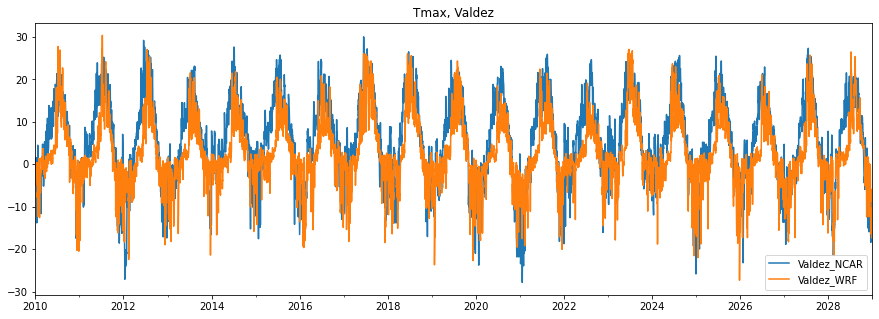

In [127]:
tmax_df_proj[["Valdez_NCAR", "Valdez_WRF"]].plot(figsize=(15,5), title="Tmax, Valdez")